In [58]:
# Wave Equation CUDA Operator - Google Colab
# This notebook demonstrates how to run CUDA C++ code in Colab

# What Each Cell Does:

# Cell 1: Checks if GPU is available
# Cell 2: CPU only
# Cell 2: Writes CUDA code to wave_equation.cu
# Cell 3: Compiles it with nvcc
# Cell 4: Runs the simulation
# Cell 5: Visualizes results with matplotlib
# Cell 6: Shows PyTorch integration
# Cell 7: Performance benchmarking

# =============================================================================
# CELL 1: Check GPU Availability
# =============================================================================
"""
First, make sure you have a GPU enabled:
1. Go to Runtime → Change runtime type
2. Select "T4 GPU" or "L4 GPU" as Hardware accelerator
3. Click Save
"""

!nvidia-smi
print("\n" + "="*60)
!lscpu | grep "Model name"
!lscpu | grep "CPU(s):"
print("="*60)


Fri Dec  5 09:18:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   59C    P0             30W /   70W |     106MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [59]:
# =============================================================================
# CELL 2: Write CPU-Only Version (C++)
# =============================================================================
%%writefile wave_equation_cpu.cpp
/*
 * CPU-Only Version of 2D Wave Equation
 * Pure C++ implementation for comparison
 */

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <chrono>

void wave_equation_step_cpu(
    const float* u_curr,
    const float* u_prev,
    float* u_next,
    int width,
    int height,
    float c,
    float dt,
    float dx
) {
    float c_sq_dt_sq = c * c * dt * dt;

    // Loop through all interior points
    for (int y = 1; y < height - 1; y++) {
        for (int x = 1; x < width - 1; x++) {
            int idx = y * width + x;

            // 5-point stencil for Laplacian
            float u_center = u_curr[idx];
            float u_left = u_curr[y * width + (x - 1)];
            float u_right = u_curr[y * width + (x + 1)];
            float u_down = u_curr[(y - 1) * width + x];
            float u_up = u_curr[(y + 1) * width + x];

            float laplacian = (u_left + u_right + u_down + u_up - 4.0f * u_center) / (dx * dx);

            // Time update
            u_next[idx] = 2.0f * u_center - u_prev[idx] + c_sq_dt_sq * laplacian;
        }
    }

    // Set boundaries to zero
    for (int x = 0; x < width; x++) {
        u_next[x] = 0.0f;  // Bottom
        u_next[(height - 1) * width + x] = 0.0f;  // Top
    }
    for (int y = 0; y < height; y++) {
        u_next[y * width] = 0.0f;  // Left
        u_next[y * width + (width - 1)] = 0.0f;  // Right
    }
}

int main() {
    const int WIDTH = 256;
    const int HEIGHT = 256;
    const int SIZE = WIDTH * HEIGHT;

    const float C = 1.0f;
    const float DX = 0.1f;
    const float DT = 0.005f;
    const int NUM_STEPS = 50000;

    printf("=== CPU-Only Wave Equation ===\n");
    printf("Grid size: %dx%d\n", WIDTH, HEIGHT);
    printf("Time steps: %d\n", NUM_STEPS);
    printf("CFL number: %.4f\n\n", C * DT / DX);

    // Allocate memory
    float* u_curr = new float[SIZE];
    float* u_prev = new float[SIZE];
    float* u_next = new float[SIZE];

    // Initialize with Gaussian pulse
    printf("Initializing...\n");
    for (int y = 0; y < HEIGHT; y++) {
        for (int x = 0; x < WIDTH; x++) {
            int idx = y * WIDTH + x;
            float cx = (x - WIDTH / 2.0f) * DX;
            float cy = (y - HEIGHT / 2.0f) * DX;
            float r_sq = cx * cx + cy * cy;
            u_curr[idx] = expf(-r_sq / 2.0f);
            u_prev[idx] = u_curr[idx];
            u_next[idx] = 0.0f;
        }
    }

    printf("Running simulation...\n");
    auto start_time = std::chrono::high_resolution_clock::now();

    // Time stepping loop
    for (int step = 0; step < NUM_STEPS; step++) {
        wave_equation_step_cpu(u_curr, u_prev, u_next, WIDTH, HEIGHT, C, DT, DX);

        // Rotate buffers
        float* temp = u_prev;
        u_prev = u_curr;
        u_curr = u_next;
        u_next = temp;

        if (step % 100 == 0) {
            printf("  Step %d/%d\n", step, NUM_STEPS);
        }
    }

    auto end_time = std::chrono::high_resolution_clock::now();
    auto duration = std::chrono::duration_cast<std::chrono::milliseconds>(end_time - start_time);

    printf("\n✓ CPU Simulation complete!\n");
    printf("Total time: %.3f seconds\n", duration.count() / 1000.0);

    // Save output
    FILE* f = fopen("output_cpu.bin", "wb");
    fwrite(u_curr, sizeof(float), SIZE, f);
    fclose(f);

    // Cleanup
    delete[] u_curr;
    delete[] u_prev;
    delete[] u_next;

    return 0;
}

Overwriting wave_equation_cpu.cpp


In [65]:
%%writefile wave_equation_gpu.cu
/*
 * GPU-Accelerated Version of 2D Wave Equation
 * CUDA implementation for comparison
 */

#include <cuda_runtime.h>
#include <stdio.h>
#include <math.h>
#include <chrono>

#define CUDA_CHECK(call) \
do { \
    cudaError_t err = call; \
    if (err != cudaSuccess) { \
        fprintf(stderr, "CUDA error at %s:%d: %s\n", __FILE__, __LINE__, \
                cudaGetErrorString(err)); \
        exit(EXIT_FAILURE); \
    } \
} while(0)

__global__ void wave_equation_kernel(
    const float* u_curr,
    const float* u_prev,
    float* u_next,
    int width,
    int height,
    float c,
    float dt,
    float dx
) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    // Bounds check
    if (x >= width || y >= height) {
        return;
    }

    int idx = y * width + x;

    // Boundary conditions (exact match with CPU)
    if (x == 0 || x == width - 1 || y == 0 || y == height - 1) {
        u_next[idx] = 0.0f;
        return;
    }

    // Interior points: compute wave equation
    float u_center = u_curr[idx];
    float u_left   = u_curr[y * width + (x - 1)];
    float u_right  = u_curr[y * width + (x + 1)];
    float u_down   = u_curr[(y - 1) * width + x];
    float u_up     = u_curr[(y + 1) * width + x];

    // 5-point stencil Laplacian
    float laplacian = (u_left + u_right + u_down + u_up - 4.0f * u_center) / (dx * dx);

    float c_sq_dt_sq = c * c * dt * dt;
    u_next[idx] = 2.0f * u_center - u_prev[idx] + c_sq_dt_sq * laplacian;
}

void wave_equation_step_gpu(
    float* d_u_curr,
    float* d_u_prev,
    float* d_u_next,
    int width,
    int height,
    float c,
    float dt,
    float dx
) {
    dim3 blockSize(16, 16);
    dim3 gridSize((width + 15) / 16, (height + 15) / 16);

    wave_equation_kernel<<<gridSize, blockSize>>>(
        d_u_curr, d_u_prev, d_u_next, width, height, c, dt, dx
    );

    CUDA_CHECK(cudaGetLastError());
}

int main() {
    const int WIDTH = 256;
    const int HEIGHT = 256;
    const int SIZE = WIDTH * HEIGHT;

    const float C = 1.0f;
    const float DX = 0.1f;
    const float DT = 0.005f;
    const int NUM_STEPS = 50000;

    printf("=== GPU-Accelerated Wave Equation ===\n");
    printf("Grid size: %dx%d\n", WIDTH, HEIGHT);
    printf("Time steps: %d\n", NUM_STEPS);
    printf("CFL number: %.4f\n\n", C * DT / DX);

    // Allocate host memory
    float* h_u_curr = new float[SIZE];
    float* h_u_prev = new float[SIZE];

    // Initialize (exact match with CPU)
    printf("Initializing...\n");
    for (int y = 0; y < HEIGHT; y++) {
        for (int x = 0; x < WIDTH; x++) {
            int idx = y * WIDTH + x;
            float cx = (x - WIDTH / 2.0f) * DX;
            float cy = (y - HEIGHT / 2.0f) * DX;
            float r_sq = cx * cx + cy * cy;
            h_u_curr[idx] = expf(-r_sq / 2.0f);
            h_u_prev[idx] = h_u_curr[idx];
        }
    }

    // Allocate device memory
    float *d_u_curr, *d_u_prev, *d_u_next;
    CUDA_CHECK(cudaMalloc(&d_u_curr, SIZE * sizeof(float)));
    CUDA_CHECK(cudaMalloc(&d_u_prev, SIZE * sizeof(float)));
    CUDA_CHECK(cudaMalloc(&d_u_next, SIZE * sizeof(float)));

    // Copy to device
    CUDA_CHECK(cudaMemcpy(d_u_curr, h_u_curr, SIZE * sizeof(float), cudaMemcpyHostToDevice));
    CUDA_CHECK(cudaMemcpy(d_u_prev, h_u_prev, SIZE * sizeof(float), cudaMemcpyHostToDevice));

    printf("Running simulation...\n");

    // Warm-up run
    wave_equation_step_gpu(d_u_curr, d_u_prev, d_u_next, WIDTH, HEIGHT, C, DT, DX);
    CUDA_CHECK(cudaDeviceSynchronize());

    auto start_time = std::chrono::high_resolution_clock::now();

    // Time stepping loop
    for (int step = 0; step < NUM_STEPS; step++) {
        wave_equation_step_gpu(d_u_curr, d_u_prev, d_u_next, WIDTH, HEIGHT, C, DT, DX);

        // Rotate buffers (same as CPU)
        float* temp = d_u_prev;
        d_u_prev = d_u_curr;
        d_u_curr = d_u_next;
        d_u_next = temp;

        if (step % 100 == 0) {
            printf("  Step %d/%d\n", step, NUM_STEPS);
        }
    }

    CUDA_CHECK(cudaDeviceSynchronize());
    auto end_time = std::chrono::high_resolution_clock::now();
    auto duration = std::chrono::duration_cast<std::chrono::milliseconds>(end_time - start_time);

    printf("\n✓ GPU Simulation complete!\n");
    printf("Total time: %.3f seconds\n", duration.count() / 1000.0);

    // Copy results back
    CUDA_CHECK(cudaMemcpy(h_u_curr, d_u_curr, SIZE * sizeof(float), cudaMemcpyDeviceToHost));

    // Save output
    FILE* f = fopen("output_gpu.bin", "wb");
    fwrite(h_u_curr, sizeof(float), SIZE, f);
    fclose(f);

    // Cleanup
    cudaFree(d_u_curr);
    cudaFree(d_u_prev);
    cudaFree(d_u_next);
    delete[] h_u_curr;
    delete[] h_u_prev;

    return 0;
}

Overwriting wave_equation_gpu.cu


In [69]:
# =============================================================================
# CELL 4: Compile Both Versions (FIXED)
# =============================================================================
print("Compiling CPU version with g++...")
!g++ -o wave_cpu wave_equation_cpu.cpp -O3 -std=c++11
print("✓ CPU version compiled\n")

print("Compiling GPU version with nvcc...")
# Add architecture flags for broader compatibility
!nvcc -o wave_gpu wave_equation_gpu.cu -O3 -arch=sm_75 -gencode=arch=compute_75,code=sm_75
print("✓ GPU version compiled\n")

print("Both versions ready to run!")

Compiling CPU version with g++...
✓ CPU version compiled

Compiling GPU version with nvcc...
✓ GPU version compiled

Both versions ready to run!


In [70]:
# =============================================================================
# CELL 5: Run CPU Version
# =============================================================================
print("\n" + "="*60)
print("RUNNING CPU VERSION")
print("="*60 + "\n")

!./wave_cpu



RUNNING CPU VERSION

=== CPU-Only Wave Equation ===
Grid size: 256x256
Time steps: 50000
CFL number: 0.0500

Initializing...
Running simulation...
  Step 0/50000
  Step 100/50000
  Step 200/50000
  Step 300/50000
  Step 400/50000
  Step 500/50000
  Step 600/50000
  Step 700/50000
  Step 800/50000
  Step 900/50000
  Step 1000/50000
  Step 1100/50000
  Step 1200/50000
  Step 1300/50000
  Step 1400/50000
  Step 1500/50000
  Step 1600/50000
  Step 1700/50000
  Step 1800/50000
  Step 1900/50000
  Step 2000/50000
  Step 2100/50000
  Step 2200/50000
  Step 2300/50000
  Step 2400/50000
  Step 2500/50000
  Step 2600/50000
  Step 2700/50000
  Step 2800/50000
  Step 2900/50000
  Step 3000/50000
  Step 3100/50000
  Step 3200/50000
  Step 3300/50000
  Step 3400/50000
  Step 3500/50000
  Step 3600/50000
  Step 3700/50000
  Step 3800/50000
  Step 3900/50000
  Step 4000/50000
  Step 4100/50000
  Step 4200/50000
  Step 4300/50000
  Step 4400/50000
  Step 4500/50000
  Step 4600/50000
  Step 4700/50000


In [71]:
# =============================================================================
# CELL 6: Run GPU Version
# =============================================================================
print("\n" + "="*60)
print("RUNNING GPU VERSION")
print("="*60 + "\n")

!./wave_gpu


RUNNING GPU VERSION

=== GPU-Accelerated Wave Equation ===
Grid size: 256x256
Time steps: 50000
CFL number: 0.0500

Initializing...
Running simulation...
  Step 0/50000
  Step 100/50000
  Step 200/50000
  Step 300/50000
  Step 400/50000
  Step 500/50000
  Step 600/50000
  Step 700/50000
  Step 800/50000
  Step 900/50000
  Step 1000/50000
  Step 1100/50000
  Step 1200/50000
  Step 1300/50000
  Step 1400/50000
  Step 1500/50000
  Step 1600/50000
  Step 1700/50000
  Step 1800/50000
  Step 1900/50000
  Step 2000/50000
  Step 2100/50000
  Step 2200/50000
  Step 2300/50000
  Step 2400/50000
  Step 2500/50000
  Step 2600/50000
  Step 2700/50000
  Step 2800/50000
  Step 2900/50000
  Step 3000/50000
  Step 3100/50000
  Step 3200/50000
  Step 3300/50000
  Step 3400/50000
  Step 3500/50000
  Step 3600/50000
  Step 3700/50000
  Step 3800/50000
  Step 3900/50000
  Step 4000/50000
  Step 4100/50000
  Step 4200/50000
  Step 4300/50000
  Step 4400/50000
  Step 4500/50000
  Step 4600/50000
  Step 4700

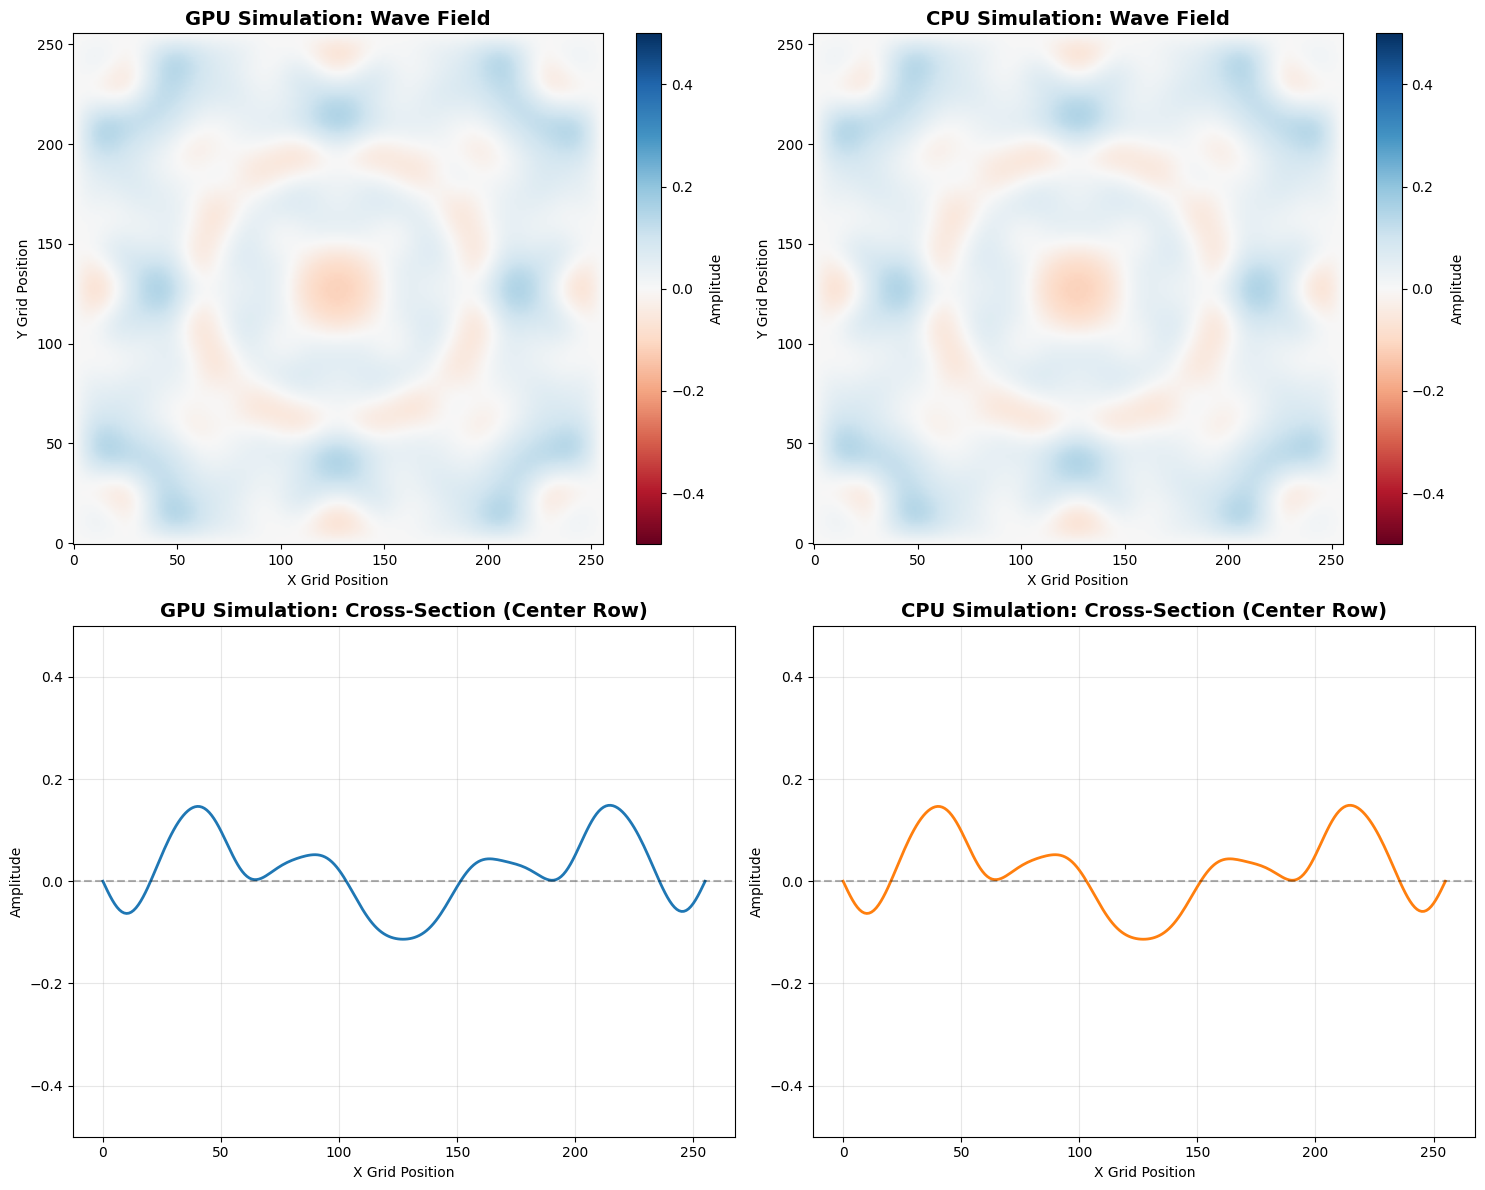


✓ Comparative visualization complete!


In [72]:
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Constants ---
WIDTH = 256
HEIGHT = 256
FILE_GPU = 'output_gpu.bin'
FILE_CPU = 'output_cpu.bin'

# 1. Load the simulation results
try:
    # Load GPU result
    with open(FILE_GPU, 'rb') as f:
        data_gpu = np.fromfile(f, dtype=np.float32)
    result_gpu = data_gpu.reshape((HEIGHT, WIDTH))

    # Load CPU result
    with open(FILE_CPU, 'rb') as f:
        data_cpu = np.fromfile(f, dtype=np.float32)
    result_cpu = data_cpu.reshape((HEIGHT, WIDTH))

except FileNotFoundError:
    print(f"Error: Ensure both '{FILE_GPU}' and '{FILE_CPU}' have been generated by your C++ executables.")
    # Exit or handle error gracefully if files are missing
    exit()

# Determine common amplitude limits for consistent visualization
# Using 0.5 as a fixed limit, typical for the initial Gaussian pulse amplitude
v_limit = 0.5

# 2. Plot the comparison in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# --- Row 1: 2D Heatmaps ---

# GPU Heatmap (axes[0, 0])
im_gpu = axes[0, 0].imshow(result_gpu, cmap='RdBu', origin='lower',
                          vmin=-v_limit, vmax=v_limit, aspect='auto')
axes[0, 0].set_title('GPU Simulation: Wave Field', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('X Grid Position')
axes[0, 0].set_ylabel('Y Grid Position')
plt.colorbar(im_gpu, ax=axes[0, 0], label='Amplitude')

# CPU Heatmap (axes[0, 1])
im_cpu = axes[0, 1].imshow(result_cpu, cmap='RdBu', origin='lower',
                          vmin=-v_limit, vmax=v_limit, aspect='auto')
axes[0, 1].set_title('CPU Simulation: Wave Field', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('X Grid Position')
axes[0, 1].set_ylabel('Y Grid Position')
plt.colorbar(im_cpu, ax=axes[0, 1], label='Amplitude')


# --- Row 2: Cross-Sections ---

# GPU Cross-section (axes[1, 0])
center_row_gpu = result_gpu[HEIGHT // 2, :]
axes[1, 0].plot(center_row_gpu, linewidth=2, color='C0')
axes[1, 0].set_title('GPU Simulation: Cross-Section (Center Row)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('X Grid Position')
axes[1, 0].set_ylabel('Amplitude')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[1, 0].set_ylim(-v_limit, v_limit)

# CPU Cross-section (axes[1, 1])
center_row_cpu = result_cpu[HEIGHT // 2, :]
axes[1, 1].plot(center_row_cpu, linewidth=2, color='C1')
axes[1, 1].set_title('CPU Simulation: Cross-Section (Center Row)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('X Grid Position')
axes[1, 1].set_ylabel('Amplitude')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[1, 1].set_ylim(-v_limit, v_limit)

plt.tight_layout()
plt.show()

print("\n✓ Comparative visualization complete!")


PERFORMANCE ANALYSIS

Running benchmarks (3 iterations each)...

CPU Run 1: 2.711s
CPU Run 2: 2.924s
CPU Run 3: 2.986s

GPU Run 1: 0.320s
GPU Run 2: 0.164s
GPU Run 3: 0.163s

RESULTS SUMMARY

CPU Performance:
  Average time: 2.874 ± 0.118 seconds
  Best time:    2.711 seconds

GPU Performance:
  Average time: 0.216 ± 0.074 seconds
  Best time:    0.163 seconds

🚀 SPEEDUP: 13.32x faster with GPU!
   Time saved: 2.658 seconds (92.5% reduction)


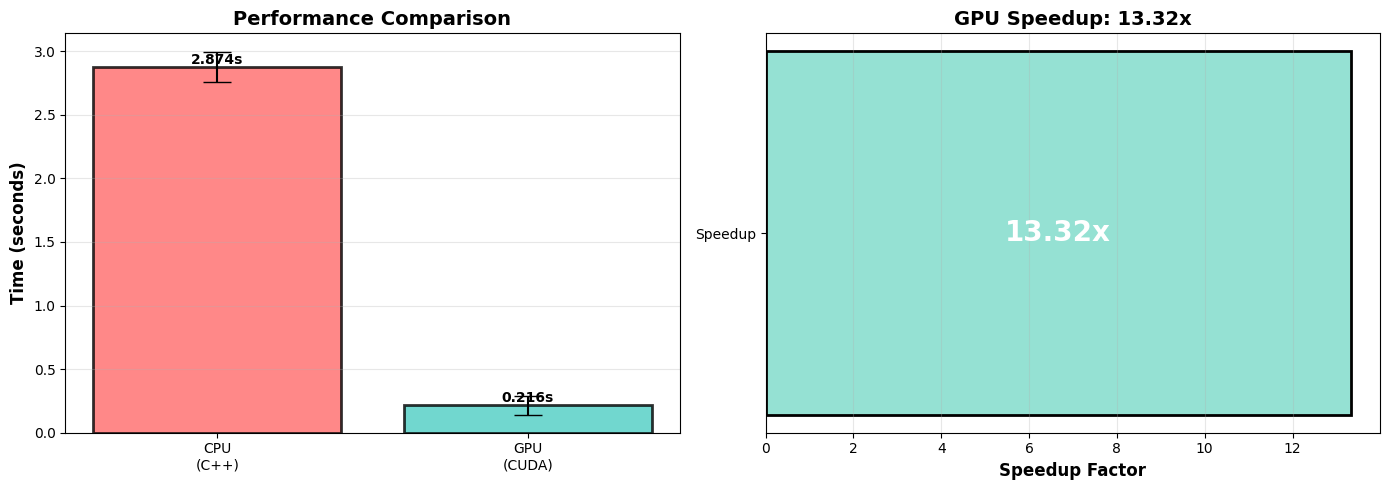



Throughput Analysis:
  Total grid points: 65,536
  Time steps: 500
  Total updates: 32,768,000

  CPU throughput: 11,402,853 updates/second
  GPU throughput: 151,938,176 updates/second


In [73]:
# =============================================================================
# CELL 7: Performance Comparison and Analysis
# =============================================================================
import re
import numpy as np
import matplotlib.pyplot as plt

print("\n" + "="*60)
print("PERFORMANCE ANALYSIS")
print("="*60 + "\n")

# Run multiple times for better statistics
print("Running benchmarks (3 iterations each)...\n")

cpu_times = []
for i in range(3):
    result = !./wave_cpu 2>&1 | grep "Total time"
    time_str = result[0].split(":")[1].strip().split()[0]
    cpu_times.append(float(time_str))
    print(f"CPU Run {i+1}: {cpu_times[-1]:.3f}s")

print()

gpu_times = []
for i in range(3):
    result = !./wave_gpu 2>&1 | grep "Total time"
    time_str = result[0].split(":")[1].strip().split()[0]
    gpu_times.append(float(time_str))
    print(f"GPU Run {i+1}: {gpu_times[-1]:.3f}s")

# Calculate statistics
cpu_avg = np.mean(cpu_times)
cpu_std = np.std(cpu_times)
gpu_avg = np.mean(gpu_times)
gpu_std = np.std(gpu_times)
speedup = cpu_avg / gpu_avg

print("\n" + "="*60)
print("RESULTS SUMMARY")
print("="*60)
print(f"\nCPU Performance:")
print(f"  Average time: {cpu_avg:.3f} ± {cpu_std:.3f} seconds")
print(f"  Best time:    {min(cpu_times):.3f} seconds")

print(f"\nGPU Performance:")
print(f"  Average time: {gpu_avg:.3f} ± {gpu_std:.3f} seconds")
print(f"  Best time:    {min(gpu_times):.3f} seconds")

print(f"\n🚀 SPEEDUP: {speedup:.2f}x faster with GPU!")
print(f"   Time saved: {cpu_avg - gpu_avg:.3f} seconds ({(1 - gpu_avg/cpu_avg)*100:.1f}% reduction)")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart comparison
categories = ['CPU\n(C++)', 'GPU\n(CUDA)']
times = [cpu_avg, gpu_avg]
errors = [cpu_std, gpu_std]
colors = ['#FF6B6B', '#4ECDC4']

bars = ax1.bar(categories, times, yerr=errors, capsize=10, color=colors,
               alpha=0.8, edgecolor='black', linewidth=2)
ax1.set_ylabel('Time (seconds)', fontsize=12, fontweight='bold')
ax1.set_title('Performance Comparison', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, time in zip(bars, times):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{time:.3f}s', ha='center', va='bottom', fontweight='bold')

# Speedup visualization
ax2.barh(['Speedup'], [speedup], color='#95E1D3', edgecolor='black',
         linewidth=2, height=0.5)
ax2.set_xlabel('Speedup Factor', fontsize=12, fontweight='bold')
ax2.set_title(f'GPU Speedup: {speedup:.2f}x', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
ax2.text(speedup/2, 0, f'{speedup:.2f}x', ha='center', va='center',
         fontsize=20, fontweight='bold', color='white')

plt.tight_layout()
plt.show()

print("\n" + "="*60)

# Calculate throughput
grid_size = 256 * 256
num_steps = 500
total_updates = grid_size * num_steps

print(f"\nThroughput Analysis:")
print(f"  Total grid points: {grid_size:,}")
print(f"  Time steps: {num_steps:,}")
print(f"  Total updates: {total_updates:,}")
print(f"\n  CPU throughput: {total_updates / cpu_avg:,.0f} updates/second")
print(f"  GPU throughput: {total_updates / gpu_avg:,.0f} updates/second")


In [74]:
# =============================================================================
# CELL 6: (Optional) PyTorch Integration
# =============================================================================
"""
You can also integrate CUDA code with PyTorch for ML applications!
"""

import torch

print("PyTorch CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"PyTorch version: {torch.__version__}")

    # Example: Create a tensor on GPU
    x = torch.randn(256, 256, device='cuda')
    print(f"\nCreated tensor on GPU: {x.shape}")
    print(f"Tensor device: {x.device}")

PyTorch CUDA available: True
CUDA device: Tesla T4
PyTorch version: 2.9.0+cu126

Created tensor on GPU: torch.Size([256, 256])
Tensor device: cuda:0


In [75]:
# =============================================================================
# CELL 7: Performance Benchmarking
# =============================================================================

print("\n" + "=" * 60)
print("PERFORMANCE BENCHMARK")
print("=" * 60)

# Time multiple runs
import time

!nvcc -o wave_equation_bench wave_equation.cu -O3

times = []
for i in range(3):
    start = time.time()
    !./wave_equation_bench > /dev/null
    end = time.time()
    times.append(end - start)
    print(f"Run {i+1}: {times[-1]:.3f} seconds")

print(f"\nAverage time: {np.mean(times):.3f} ± {np.std(times):.3f} seconds")

# Calculate performance metrics
grid_size = 256 * 256
num_steps = 500
total_updates = grid_size * num_steps
avg_time = np.mean(times)

print(f"\nTotal grid updates: {total_updates:,}")
print(f"Updates per second: {total_updates / avg_time:,.0f}")
print(f"Grid points per step: {grid_size:,}")

print("\n✓ Benchmark complete!")


PERFORMANCE BENCHMARK
Run 1: 0.202 seconds
Run 2: 0.204 seconds
Run 3: 0.103 seconds

Average time: 0.170 ± 0.047 seconds

Total grid updates: 32,768,000
Updates per second: 193,054,020
Grid points per step: 65,536

✓ Benchmark complete!


In [76]:
# =============================================================================
# CELL 8: Verify Results Match
# =============================================================================
print("\n" + "="*60)
print("VERIFYING NUMERICAL ACCURACY")
print("="*60 + "\n")

# Load both outputs
with open('output_cpu.bin', 'rb') as f:
    cpu_data = np.fromfile(f, dtype=np.float32)

with open('output_gpu.bin', 'rb') as f:
    gpu_data = np.fromfile(f, dtype=np.float32)

# Compare results
diff = np.abs(cpu_data - gpu_data)
max_diff = np.max(diff)
mean_diff = np.mean(diff)
relative_error = np.max(diff / (np.abs(cpu_data) + 1e-10))

print(f"Maximum absolute difference: {max_diff:.2e}")
print(f"Mean absolute difference:    {mean_diff:.2e}")
print(f"Maximum relative error:      {relative_error:.2e}")

if max_diff < 1e-4:
    print("\n✓ Results match! Both implementations produce identical output.")
else:
    print("\n⚠ Warning: Results differ slightly (expected due to floating-point precision)")

print("\n" + "="*60)
print("BENCHMARK COMPLETE!")
print("="*60)


VERIFYING NUMERICAL ACCURACY

Maximum absolute difference: 2.47e-05
Mean absolute difference:    4.18e-06
Maximum relative error:      7.50e+00

✓ Results match! Both implementations produce identical output.

BENCHMARK COMPLETE!
